In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [10]:
def read_summaries(dataset, method, stage):
    df = pd.read_csv(f"results/{dataset}/{stage}/{method}_summaries.csv")
    summaries = [group for _, group in df.groupby("run_id")]
    return summaries



In [3]:
def read_summaries(dataset, method, stage):
    file_path = f"results/{dataset}/{stage}/{method}_summaries.csv"
    if os.path.getsize(file_path) > 0:  # Check if file is not empty
        df = pd.read_csv(file_path)
        df["method"] = method  # Add a column to indicate the method
        df["dataset"] = dataset  # Add a column to indicate the dataset
        return df
    else:
        print(f"File {file_path} is empty.")
        return pd.DataFrame()  # Return an empty DataFrame

# List of methods
methods = [
    "regular",
    "vibcreg_warp",
    "vibcreg_slice",
    "vibcreg_gauss",
    "barlowtwins_warp",
    "barlowtwins_slice",
    "barlowtwins_gauss",
]

datasets = [
    "ElectricDevices",
    "FordB",
    "FordA",
    "Wafer",
    "TwoPatterns",
    "StarLightCurves",
    "UWaveGestureLibraryAll",
    "ECG5000",
    "ShapesAll",
    "Mallat",
    "Symbols",
    "SonyAIBORobotSurface1",
    "SonyAIBORobotSurface2",
]

# Read the summaries for all methods and all datasets into a single DataFrame
all_summaries_stage1 = pd.concat([read_summaries(dataset, method, "stage1") for dataset in datasets for method in methods])
all_summaries_stage2 = pd.concat([read_summaries(dataset, method, "stage2") for dataset in datasets for method in methods])

all_summaries = pd.concat([read_summaries(dataset, method, stage) for dataset in datasets for method in methods for stage in ["stage1", "stage2"]])

dfs = {method: all_summaries[all_summaries['method'] == method] for method in methods}




In [154]:
all_summaries_stage1

summary_df_stage1_mean= all_summaries_stage1.groupby(['method', 'dataset'])[['svm_accuracy', 'knn_accuracy']].agg(
    svm_accuracy_mean=('svm_accuracy', 'mean'),
    knn_accuracy_mean=('knn_accuracy', 'mean')
    ).reset_index()
summary_df_stage2_mean = all_summaries_stage2.groupby(['method', 'dataset'])[['FID', 'IS_mean']].agg(
    IS_mean_mean=('IS_mean', 'mean'),
    FID_mean=('FID', 'mean')
    ).reset_index()


summary_df_stage1_best = all_summaries_stage1.groupby(['method', 'dataset'])[['svm_accuracy', 'knn_accuracy']].agg(
    svm_accuracy_max=('svm_accuracy', 'max'),
    knn_accuracy_max=('knn_accuracy', 'min')
).reset_index()
summary_df_stage2_best = all_summaries_stage2.groupby(['method', 'dataset']).agg(
    IS_mean_max=('IS_mean', 'max'),
    FID_min=('FID', 'min')
).reset_index()


# summary_mean = pd.merge(summary_df_stage1_mean, summary_df_stage2_mean, how="inner")
# summary_max = pd.merge(summary_df_stage1_best, summary_df_stage2_best, how="inner")
# total_summary =  pd.merge(summary_mean, summary_max, how="inner")
# total_summary

summary_stage1 = pd.merge(summary_df_stage1_mean, summary_df_stage1_best, how="inner")
summary_stage2 = pd.merge(summary_df_stage2_mean, summary_df_stage2_best, how="inner")

def split_and_apply(df):
    def split_method(method):
        if method == "regular":
            return "regular", "none"
        else:
            parts = method.split('_')
            ssl_method = parts[0]
            aug = parts[1] if len(parts) > 1 else "none"
            return ssl_method, aug

    df[['SSL_method', 'Aug']] = df['method'].apply(lambda x: pd.Series(split_method(x)))
    df.drop(columns=['method'], inplace=True)
    return df

summary_stage1 = split_and_apply(summary_stage1)
summary_stage2 = split_and_apply(summary_stage2)

In [155]:
print(split_and_apply(summary_df_stage2_best)[summary_df_stage2_best["dataset"] == "UWaveGestureLibraryAll"])


                   dataset  IS_mean_max   FID_min   SSL_method    Aug
11  UWaveGestureLibraryAll     2.785161  7.312509  barlowtwins  gauss
24  UWaveGestureLibraryAll     3.125664  6.259955  barlowtwins  slice
37  UWaveGestureLibraryAll     2.944971  6.452598  barlowtwins   warp
50  UWaveGestureLibraryAll     2.239735  8.157989      regular   none
63  UWaveGestureLibraryAll     2.791278  7.093053      vibcreg  gauss
76  UWaveGestureLibraryAll     3.059209  6.330307      vibcreg  slice
89  UWaveGestureLibraryAll     2.989070  6.521101      vibcreg   warp


In [104]:
def plot_accuracy(ax, df, ssl_method, accuracy="svm_accuracy_max", aug_method=None, color=None, linestyle="-", label=""):
    # Filter the dataframe based on the SSL method and the augmentation method
    if aug_method:
        df_filtered = df[(df['SSL_method'] == ssl_method) & (df['Aug'] == aug_method)]
    else:
        df_filtered = df[df['SSL_method'] == ssl_method]

    # Sort the dataframe by dataset
    df_filtered = df_filtered.sort_values('dataset')

    # Plot the max SVM accuracy with a line style and color
    ax.plot(df_filtered['dataset'], df_filtered[accuracy] * 100, label=label, linestyle=linestyle, marker='o', color=color)
    ax.tick_params(axis='x', labelsize=11)  # Change the size of the x-axis labels

    return ax


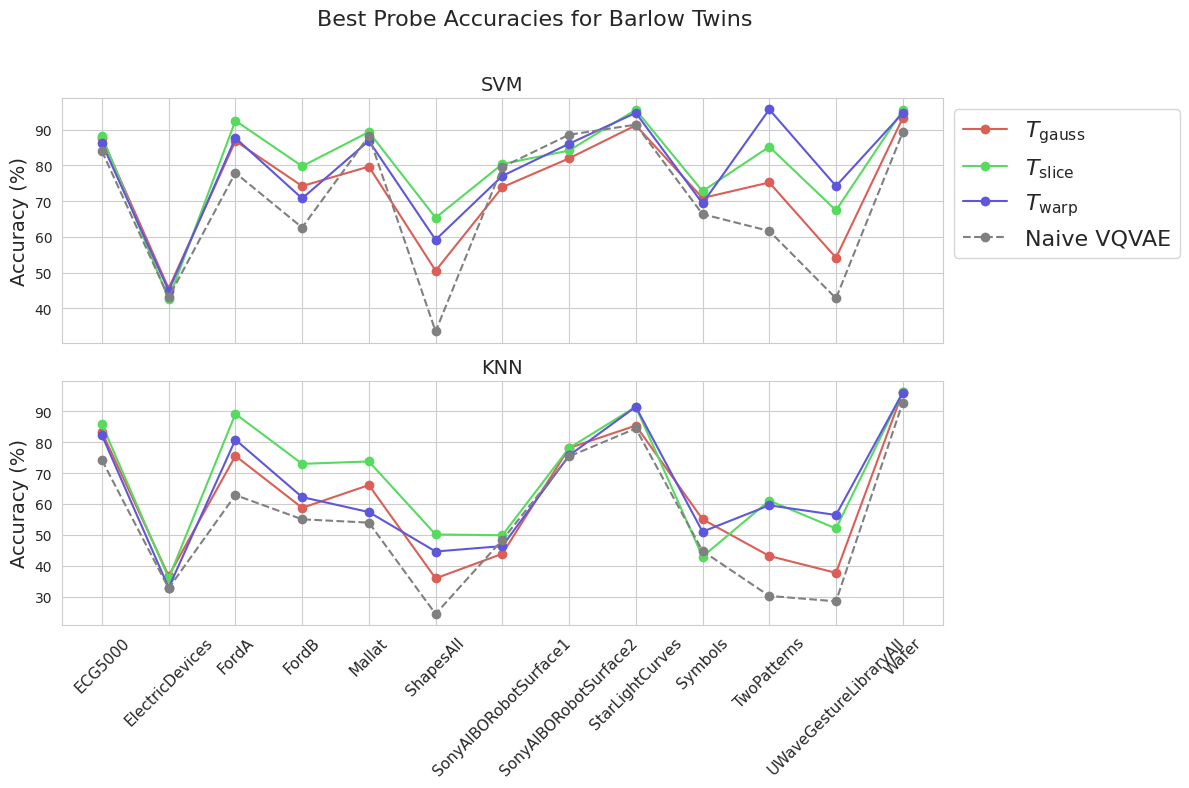

In [105]:
def plot_accuracy(ax, df, ssl_method, accuracy="svm_accuracy_max", aug_method=None, color=None, linestyle="-", label=""):
    # Filter the dataframe based on the SSL method and the augmentation method
    if aug_method:
        df_filtered = df[(df['SSL_method'] == ssl_method) & (df['Aug'] == aug_method)]
    else:
        df_filtered = df[df['SSL_method'] == ssl_method]

    # Sort the dataframe by dataset
    df_filtered = df_filtered.sort_values('dataset')

    # Plot the max SVM accuracy with a line style and color
    ax.plot(df_filtered['dataset'], df_filtered[accuracy] * 100, label=label, linestyle=linestyle, marker='o', color=color)
    ax.tick_params(axis='x', labelsize=11)  # Change the size of the x-axis labels

    return ax


# Set the style of seaborn
sns.set_style("whitegrid")

# Set the color palette of seaborn
sns.set_palette("hls", 3)

# Create a new figure
#f, a = plt.subplots(figsize=(12, 4))


# Create a new figure with two subplots that share the x-axis
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
f.suptitle("Best Probe Accuracies for Barlow Twins", fontsize=16, x=0.45)
# Plot the max SVM accuracy
ax1.set_title('SVM', fontsize=14)
ax1.set_ylabel('Accuracy (%)', fontsize=14)
ax1 = plot_accuracy(ax1, summary_stage1, ssl_method='barlowtwins', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax1 = plot_accuracy(ax1, summary_stage1, ssl_method='barlowtwins', aug_method='slice', label=r"$T_{\text{slice}}$")
ax1 = plot_accuracy(ax1, summary_stage1, ssl_method='barlowtwins', aug_method='warp', label=r"$T_{\text{warp}}$")
ax1 = plot_accuracy(ax1, summary_stage1, ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")
ax1.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))

# Plot the max KNN accuracy
ax2.set_title('KNN', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=14)
ax2 = plot_accuracy(ax2, summary_stage1, accuracy="knn_accuracy_max", ssl_method='barlowtwins', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax2 = plot_accuracy(ax2, summary_stage1, accuracy="knn_accuracy_max", ssl_method='barlowtwins', aug_method='slice', label=r"$T_{\text{slice}}$")
ax2 = plot_accuracy(ax2, summary_stage1, accuracy="knn_accuracy_max", ssl_method='barlowtwins', aug_method='warp', label=r"$T_{\text{warp}}$")
ax2 = plot_accuracy(ax2, summary_stage1, accuracy="knn_accuracy_max", ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")
#ax2.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate the suptitle
#plt.savefig("probes_barlow_twins.pdf")
plt.show()

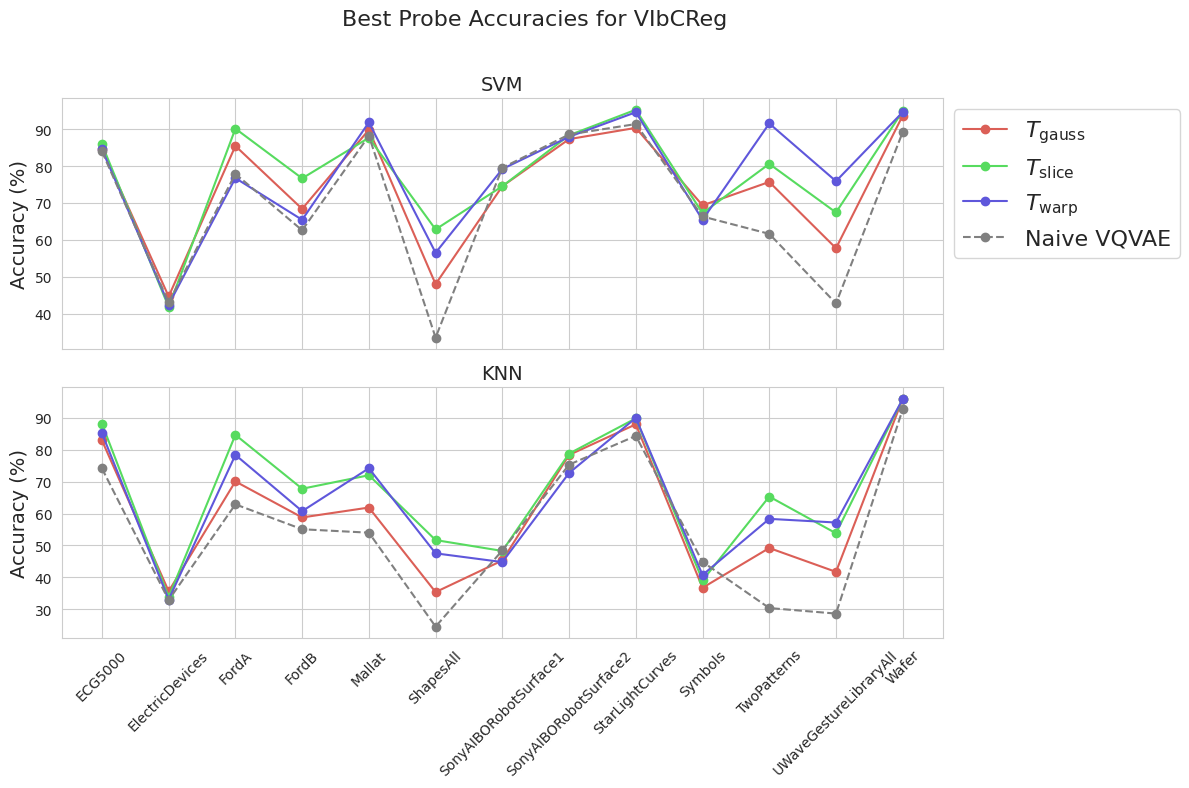

In [96]:
# Set the style of seaborn
sns.set_style("whitegrid")

# Set the color palette of seaborn
sns.set_palette("hls", 3)

# Create a new figure
#f, a = plt.subplots(figsize=(12, 4))


# Create a new figure with two subplots that share the x-axis
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
f.suptitle("Best Probe Accuracies for VIbCReg", fontsize=16, x=0.45)
# Plot the max SVM accuracy
ax1.set_title('SVM', fontsize=14)
ax1.set_ylabel('Accuracy (%)', fontsize=14)
ax1 = plot_accuracy(ax1, summary_stage1, ssl_method='vibcreg', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax1 = plot_accuracy(ax1, summary_stage1, ssl_method='vibcreg', aug_method='slice', label=r"$T_{\text{slice}}$")
ax1 = plot_accuracy(ax1, summary_stage1, ssl_method='vibcreg', aug_method='warp', label=r"$T_{\text{warp}}$")
ax1 = plot_accuracy(ax1, summary_stage1, ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")
ax1.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))

# Plot the max KNN accuracy
ax2.set_title('KNN', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=14)
ax2 = plot_accuracy(ax2, summary_stage1, accuracy="knn_accuracy_max", ssl_method='vibcreg', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax2 = plot_accuracy(ax2, summary_stage1, accuracy="knn_accuracy_max", ssl_method='vibcreg', aug_method='slice', label=r"$T_{\text{slice}}$")
ax2 = plot_accuracy(ax2, summary_stage1, accuracy="knn_accuracy_max", ssl_method='vibcreg', aug_method='warp', label=r"$T_{\text{warp}}$")
ax2 = plot_accuracy(ax2, summary_stage1, accuracy="knn_accuracy_max", ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")
#ax2.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate the suptitle
#plt.savefig("probes_vibcreg.pdf")
plt.show()

In [118]:
from matplotlib.ticker import MaxNLocator


def plot_FID(ax, df, ssl_method, aug_method=None, color=None, linestyle="-", label=""):
    # Filter the dataframe based on the SSL method and the augmentation method
    
    if aug_method:
        df_filtered = df[(df['SSL_method'] == ssl_method) & (df['Aug'] == aug_method)]
    else:
        df_filtered = df[df['SSL_method'] == ssl_method]

    # Sort the dataframe by dataset
    df_filtered = df_filtered.sort_values('dataset')



    ax.set_yscale('log')
    # Plot the max SVM accuracy with a line style and color
    ax.plot(df_filtered['dataset'], df_filtered["FID_min"], label=label, linestyle=linestyle, marker='o', color=color)
    ax.tick_params(axis='x', labelsize=11)  # Change the size of the x-axis labels
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))

    return ax

def plot_IS(ax, df, ssl_method, aug_method=None, color=None, linestyle="-", label=""):
    # Filter the dataframe based on the SSL method and the augmentation method
    if aug_method:
        df_filtered = df[(df['SSL_method'] == ssl_method) & (df['Aug'] == aug_method)]
    else:
        df_filtered = df[df['SSL_method'] == ssl_method]

    # Sort the dataframe by dataset
    df_filtered = df_filtered.sort_values('dataset')

    # Plot the max SVM accuracy with a line style and color
    ax.plot(df_filtered['dataset'], df_filtered["IS_mean_max"], label=label, linestyle=linestyle, marker='o', color=color)
    ax.tick_params(axis='x', labelsize=11)  # Change the size of the x-axis labels

    return ax

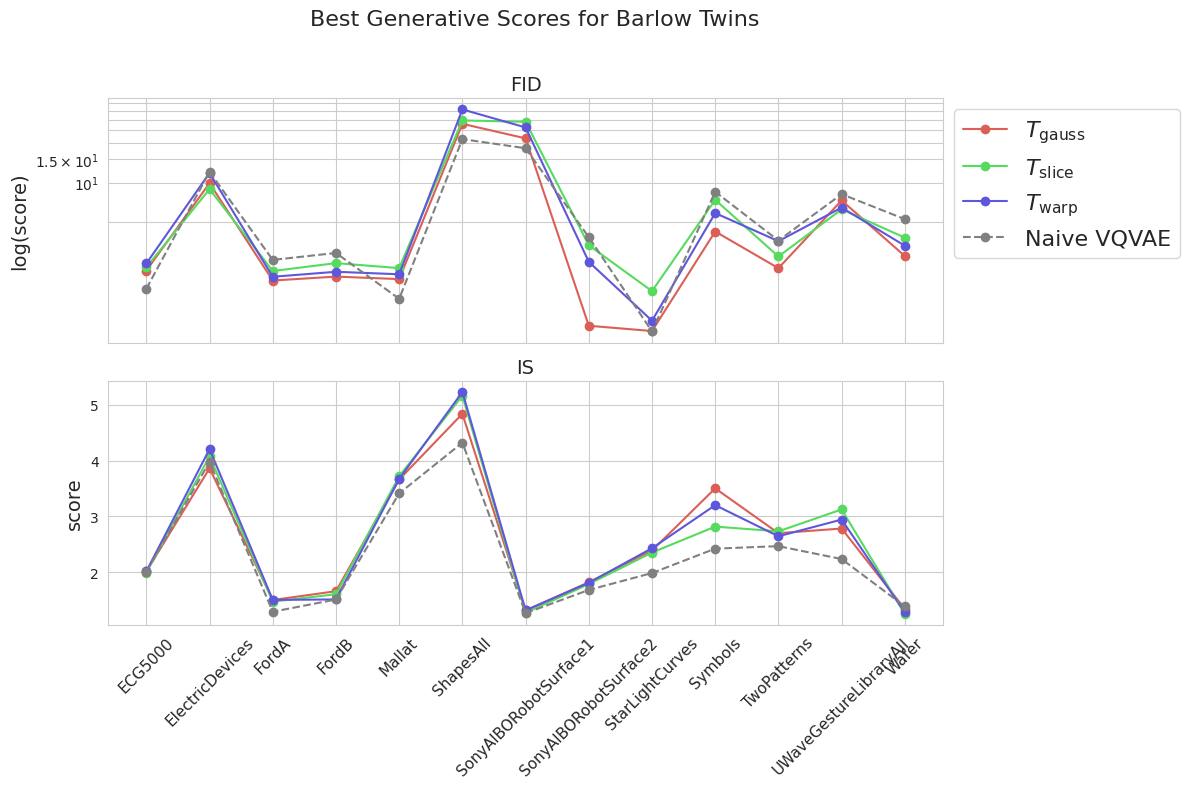

In [124]:
# Set the style of seaborn
sns.set_style("whitegrid")

# Set the color palette of seaborn
sns.set_palette("hls", 3)

# Create a new figure
#f, a = plt.subplots(figsize=(12, 4))


# Create a new figure with two subplots that share the x-axis
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
f.suptitle("Best Generative Scores for Barlow Twins", fontsize=16, x=0.45)
# Plot the max SVM accuracy

ax1.set_title('FID', fontsize=14)
ax1.set_ylabel('log(score)', fontsize=14)
ax1 = plot_FID(ax1, summary_stage2, ssl_method='barlowtwins', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax1 = plot_FID(ax1, summary_stage2, ssl_method='barlowtwins', aug_method='slice', label=r"$T_{\text{slice}}$")
ax1 = plot_FID(ax1, summary_stage2, ssl_method='barlowtwins', aug_method='warp', label=r"$T_{\text{warp}}$")
ax1 = plot_FID(ax1, summary_stage2, ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")
ax1.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))

# Plot the max KNN accuracy
acc2 = "IS_mean_max"
ax2.set_title('IS', fontsize=14)
ax2.set_ylabel('score', fontsize=14)
ax2 = plot_IS(ax2, summary_stage2, ssl_method='barlowtwins', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax2 = plot_IS(ax2, summary_stage2, ssl_method='barlowtwins', aug_method='slice', label=r"$T_{\text{slice}}$")
ax2 = plot_IS(ax2, summary_stage2, ssl_method='barlowtwins', aug_method='warp', label=r"$T_{\text{warp}}$")
ax2 = plot_IS(ax2, summary_stage2, ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")
#ax2.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate the suptitle
plt.savefig("gen_barlow_twins.pdf")
plt.show()

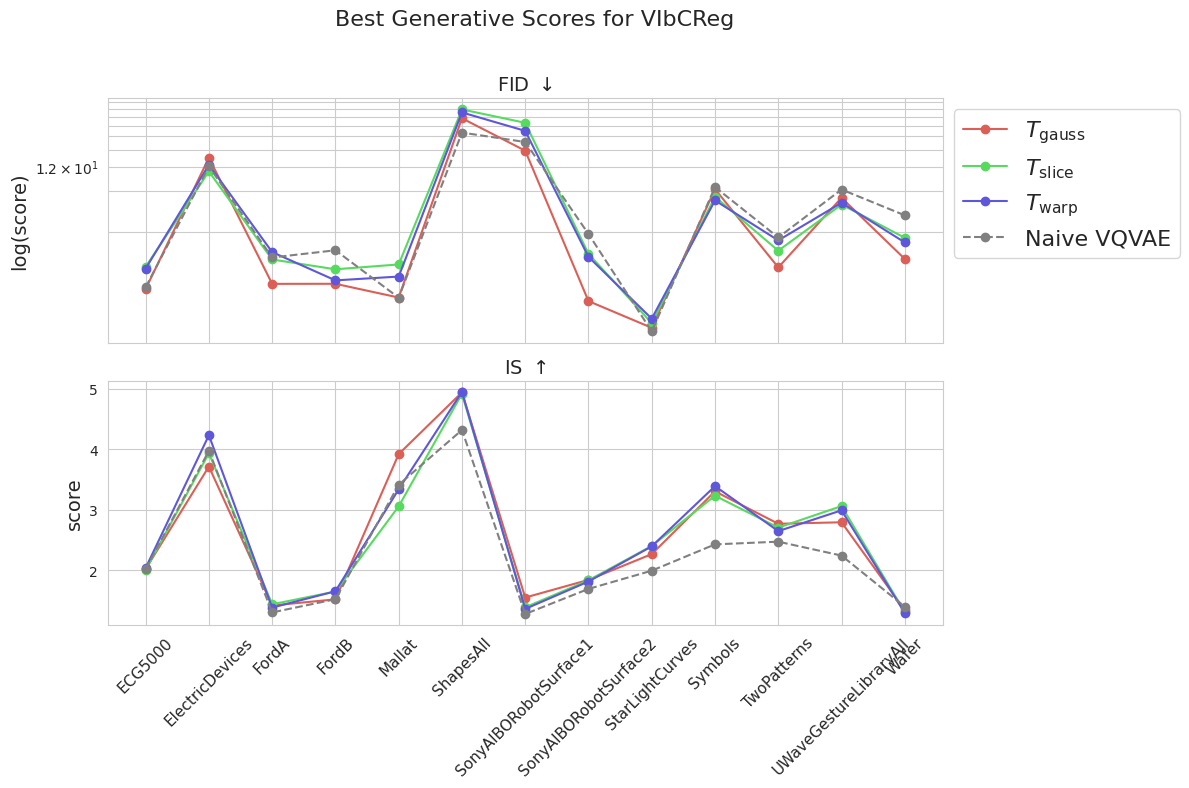

In [126]:
# Set the style of seaborn
sns.set_style("whitegrid")

# Set the color palette of seaborn
sns.set_palette("hls", 3)

# Create a new figure
#f, a = plt.subplots(figsize=(12, 4))


# Create a new figure with two subplots that share the x-axis
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
f.suptitle("Best Generative Scores for VIbCReg", fontsize=16, x=0.45)
# Plot the max SVM accuracy

ax1.set_title(r'FID $\downarrow$', fontsize=14)
ax1.set_ylabel('log(score)', fontsize=14)
ax1 = plot_FID(ax1, summary_stage2, ssl_method='vibcreg', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax1 = plot_FID(ax1, summary_stage2, ssl_method='vibcreg', aug_method='slice', label=r"$T_{\text{slice}}$")
ax1 = plot_FID(ax1, summary_stage2, ssl_method='vibcreg', aug_method='warp', label=r"$T_{\text{warp}}$")
ax1 = plot_FID(ax1, summary_stage2, ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")
ax1.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))

# Plot the max KNN accuracy
ax2.set_title(r'IS $\uparrow$', fontsize=14)
ax2.set_ylabel('score', fontsize=14)
ax2 = plot_IS(ax2, summary_stage2, ssl_method='vibcreg', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax2 = plot_IS(ax2, summary_stage2, ssl_method='vibcreg', aug_method='slice', label=r"$T_{\text{slice}}$")
ax2 = plot_IS(ax2, summary_stage2, ssl_method='vibcreg', aug_method='warp', label=r"$T_{\text{warp}}$")
ax2 = plot_IS(ax2, summary_stage2, ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")
#ax2.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate the suptitle
plt.savefig("gen_vibcreg.pdf")
plt.show()

In [127]:
# Compute differences for sorting
summary_stage2['difference'] = summary_stage2.apply(lambda row: abs(row['barlowtwins_gauss'] - row['barlowtwins_slice']) + abs(row['barlowtwins_gauss'] - row['barlowtwins_warp']) + abs(row['barlowtwins_slice'] - row['barlowtwins_warp']), axis=1)

# Sort datasets based on the computed differences
sorted_datasets = summary_stage2.sort_values(by='difference', ascending=False)['dataset']

# Update the plot data to reflect sorted datasets
summary_stage2_sorted = summary_stage2.set_index('dataset').loc[sorted_datasets].reset_index()

# Set the style of seaborn
sns.set_style("whitegrid")

# Set the color palette of seaborn
sns.set_palette("hls", 3)

# Create a new figure with two subplots that share the x-axis
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
f.suptitle("Best Generative Scores for Barlow Twins", fontsize=16, x=0.45)

# Plot the max SVM accuracy
ax1.set_title('FID', fontsize=14)
ax1.set_ylabel('log(score)', fontsize=14)
ax1 = plot_FID(ax1, summary_stage2_sorted, ssl_method='barlowtwins', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax1 = plot_FID(ax1, summary_stage2_sorted, ssl_method='barlowtwins', aug_method='slice', label=r"$T_{\text{slice}}$")
ax1 = plot_FID(ax1, summary_stage2_sorted, ssl_method='barlowtwins', aug_method='warp', label=r"$T_{\text{warp}}$")
ax1 = plot_FID(ax1, summary_stage2_sorted, ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")
ax1.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))

# Plot the max KNN accuracy
ax2.set_title('IS', fontsize=14)
ax2.set_ylabel('score', fontsize=14)
ax2 = plot_IS(ax2, summary_stage2_sorted, ssl_method='barlowtwins', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax2 = plot_IS(ax2, summary_stage2_sorted, ssl_method='barlowtwins', aug_method='slice', label=r"$T_{\text{slice}}$")
ax2 = plot_IS(ax2, summary_stage2_sorted, ssl_method='barlowtwins', aug_method='warp', label=r"$T_{\text{warp}}$")
ax2 = plot_IS(ax2, summary_stage2_sorted, ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate the suptitle
plt.savefig("gen_barlow_twins.pdf")
plt.show()

KeyError: 'barlowtwins_gauss'